In [3]:
import os, sys, torch
import cv2
import numpy as np

PROJECT_ROOT = r"D:\10.CAO HOC\2.MON HOC TREN TRUONG\2. HK1 2526\4. Applications of Machine Learning in Data Analysis\3.Project FaceMask\Dataset_Facemask_Yolo"
SRC_DIR = os.path.join(PROJECT_ROOT, "3. src")
if SRC_DIR not in sys.path:
    sys.path.append(SRC_DIR)

from b_model_yolo import YOLOv3  # hoặc model_yolo import YOLOv3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

NUM_CLASSES = 3
IMG_SIZE = 416

model = YOLOv3(num_classes=NUM_CLASSES, img_size=IMG_SIZE).to(device)

ckpt_path = os.path.join(PROJECT_ROOT, "4. Checkpoints", "yolov3", "best.pt")
ckpt = torch.load(ckpt_path, map_location=device)

# bạn lưu ckpt theo key nào thì dùng key đó
state = ckpt.get("model_state_dict", ckpt.get("model", ckpt))
model.load_state_dict(state, strict=False)

model.eval()
print("✅ Loaded:", ckpt_path)


✅ Loaded: D:\10.CAO HOC\2.MON HOC TREN TRUONG\2. HK1 2526\4. Applications of Machine Learning in Data Analysis\3.Project FaceMask\Dataset_Facemask_Yolo\4. Checkpoints\yolov3\best.pt


In [4]:
CLASS_NAMES = ["with_mask", "incorrect_mask", "without_mask"]

img_path = r"D:\10.CAO HOC\2.MON HOC TREN TRUONG\2. HK1 2526\4. Applications of Machine Learning in Data Analysis\3.Project FaceMask\Dataset_Facemask_Yolo\1.Dataset\Train\Pictures\000002.jpg"  # đổi thành ảnh bạn muốn test
img0 = cv2.imread(img_path)
img = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
x = (img.astype(np.float32)/255.0).transpose(2,0,1)
x = torch.from_numpy(x).unsqueeze(0).to(device)

with torch.no_grad():
    outputs = model(x)

print([o.shape for o in outputs])   # kiểm tra output 3 scale


[torch.Size([1, 24, 26, 26]), torch.Size([1, 24, 52, 52]), torch.Size([1, 24, 104, 104])]


In [5]:
def draw_boxes(img_bgr, boxes, scores, class_ids):
    h, w = img_bgr.shape[:2]
    for (x1,y1,x2,y2), sc, cid in zip(boxes, scores, class_ids):
        cv2.rectangle(img_bgr, (int(x1),int(y1)), (int(x2),int(y2)), (0,255,0), 2)
        cv2.putText(img_bgr, f"{CLASS_NAMES[int(cid)]}:{sc:.2f}",
                    (int(x1), int(y1)-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1)
    return img_bgr


In [6]:
# ===== DECODE YOLO OUTPUTS & NMS =====
import torch.nn.functional as F

def decode_predictions(outputs, img_size=416, conf_thresh=0.25, iou_thresh=0.45):
    """
    Decode YOLOv3 multi-scale outputs to bounding boxes.
    
    outputs: list of 3 tensors, each (B, C, H, W) where C = anchors*(5+num_classes)
    returns: (boxes, scores, class_ids) - all in image coordinates [0, img_size]
    """
    device = outputs[0].device
    anchors_per_scale = 3
    num_classes = NUM_CLASSES
    chunk = 5 + num_classes
    
    all_boxes = []
    all_scores = []
    all_class_ids = []
    
    def sigmoid(x):
        return 1.0 / (1.0 + torch.exp(-x))
    
    for scale_idx, out in enumerate(outputs):
        # out: (B, C, H, W)
        B, C, H, W = out.shape
        out = out.view(B, anchors_per_scale, chunk, H, W)
        out = out.permute(0, 1, 3, 4, 2)  # (B, anchors, H, W, chunk)
        
        for b in range(B):
            for a in range(anchors_per_scale):
                # Extract per-anchor tensors
                tx = out[b, a, :, :, 0]  # (H, W)
                ty = out[b, a, :, :, 1]
                tw = out[b, a, :, :, 2]
                th = out[b, a, :, :, 3]
                to = out[b, a, :, :, 4]  # objectness logits
                tcls = out[b, a, :, :, 5:5+num_classes]  # class logits
                
                # Compute objectness and class confidence
                obj_prob = sigmoid(to)  # (H, W)
                cls_prob = F.softmax(tcls, dim=-1)  # (H, W, num_classes)
                cls_conf, cls_id = torch.max(cls_prob, dim=-1)  # (H, W), (H, W)
                
                # Combined score: obj_prob * cls_conf
                score = (obj_prob * cls_conf).view(-1)  # (H*W,)
                
                # Filter by confidence threshold
                keep_mask = score > conf_thresh
                if not keep_mask.any():
                    continue
                
                keep_idx = torch.nonzero(keep_mask, as_tuple=False).squeeze(1)
                
                # Get grid indices
                ys = keep_idx // W
                xs = keep_idx % W
                
                # Extract values at kept indices
                txk = tx[ys, xs]
                tyk = ty[ys, xs]
                twk = tw[ys, xs]
                thk = th[ys, xs]
                sk = score[keep_idx]
                csk = cls_id[ys, xs]
                
                # Decode to image coordinates
                # Standard YOLO: cx = (x + sigmoid(tx)) * stride, etc.
                # Here we use simple scaling based on feature map size
                stride = img_size / H
                
                cx = (xs.float() + sigmoid(txk)) * stride
                cy = (ys.float() + sigmoid(tyk)) * stride
                w = torch.exp(twk) * stride
                h = torch.exp(thk) * stride
                
                x1 = torch.clamp(cx - w/2, min=0, max=img_size-1)
                y1 = torch.clamp(cy - h/2, min=0, max=img_size-1)
                x2 = torch.clamp(cx + w/2, min=0, max=img_size-1)
                y2 = torch.clamp(cy + h/2, min=0, max=img_size-1)
                
                all_boxes.append(torch.stack([x1, y1, x2, y2], dim=-1))
                all_scores.append(sk)
                all_class_ids.append(csk)
    
    if len(all_boxes) == 0:
        return torch.zeros((0, 4), device=device), torch.zeros(0, device=device), torch.zeros(0, dtype=torch.long, device=device)
    
    boxes = torch.cat(all_boxes, dim=0)  # (N, 4)
    scores = torch.cat(all_scores, dim=0)  # (N,)
    class_ids = torch.cat(all_class_ids, dim=0)  # (N,)
    
    # NMS
    def nms_torch(boxes, scores, iou_threshold=0.45):
        """Simple NMS implementation"""
        if boxes.numel() == 0:
            return torch.tensor([], dtype=torch.long, device=boxes.device)
        
        x1, y1, x2, y2 = boxes.unbind(dim=-1)
        area = (x2 - x1) * (y2 - y1)
        
        order = scores.argsort(descending=True)
        keep = []
        
        while order.numel() > 0:
            i = order[0].item()
            keep.append(i)
            if order.numel() == 1:
                break
            
            # Compute IoU
            xx1 = torch.maximum(x1[i], x1[order[1:]])
            yy1 = torch.maximum(y1[i], y1[order[1:]])
            xx2 = torch.minimum(x2[i], x2[order[1:]])
            yy2 = torch.minimum(y2[i], y2[order[1:]])
            
            inter_w = torch.clamp(xx2 - xx1, min=0)
            inter_h = torch.clamp(yy2 - yy1, min=0)
            inter = inter_w * inter_h
            
            iou = inter / (area[i] + area[order[1:]] - inter + 1e-6)
            
            keep_mask = iou <= iou_threshold
            order = order[1:][keep_mask]
        
        return torch.tensor(keep, dtype=torch.long, device=boxes.device)
    
    keep_idx = nms_torch(boxes, scores, iou_threshold=iou_thresh)
    
    return boxes[keep_idx], scores[keep_idx], class_ids[keep_idx]


# Run decoding
boxes, scores, class_ids = decode_predictions(outputs, img_size=IMG_SIZE, conf_thresh=0.25)
print(f"Detections after NMS: {len(boxes)}")
print(f"Boxes shape: {boxes.shape}, Scores shape: {scores.shape}")


Detections after NMS: 0
Boxes shape: torch.Size([0, 4]), Scores shape: torch.Size([0])


In [10]:
# ===== VISUALIZE DETECTIONS =====
import cv2
import numpy as np
import os

# Load original image (original size)
img_orig = cv2.imread(img_path)
img_orig_rgb = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)

# Draw boxes on original image
img_vis = img_orig_rgb.copy()
colors = [(0, 255, 0), (255, 0, 0), (0, 0, 255)]  # RGB colors for each class

# Scale boxes from 416x416 back to original image size
orig_h, orig_w = img_orig_rgb.shape[:2]
scale_x = orig_w / IMG_SIZE
scale_y = orig_h / IMG_SIZE

print(f"Original image size: {orig_w}x{orig_h}")
print(f"Model input size: {IMG_SIZE}x{IMG_SIZE}")
print(f"Total detections: {len(boxes)}")

if len(boxes) > 0:
    print(f"\nDetected objects:")
    for (x1, y1, x2, y2), score, class_id in zip(boxes, scores, class_ids):
        x1, y1, x2, y2 = x1.item(), y1.item(), x2.item(), y2.item()
        
        # Scale back to original image
        x1_orig = int(x1 * scale_x)
        y1_orig = int(y1 * scale_y)
        x2_orig = int(x2 * scale_x)
        y2_orig = int(y2 * scale_y)
        
        # Clamp to image bounds
        x1_orig = max(0, min(orig_w - 1, x1_orig))
        y1_orig = max(0, min(orig_h - 1, y1_orig))
        x2_orig = max(0, min(orig_w - 1, x2_orig))
        y2_orig = max(0, min(orig_h - 1, y2_orig))
        
        cid = int(class_id.item())
        conf = float(score.item())
        
        # Draw rectangle
        color = colors[cid % len(colors)]
        cv2.rectangle(img_vis, (x1_orig, y1_orig), (x2_orig, y2_orig), color, 2)
        
        # Draw label
        label = f"{CLASS_NAMES[cid]}: {conf:.2f}"
        cv2.putText(img_vis, label, (x1_orig, max(0, y1_orig - 8)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
        
        print(f"  {CLASS_NAMES[cid]} ({conf:.3f}) @ ({x1_orig}, {y1_orig}, {x2_orig}, {y2_orig})")
else:
    print("No detections found. (Model may need more training.)")

# Add "RESULT" watermark to image
cv2.putText(img_vis, "RESULT", (10, 30),
            cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 3)
cv2.putText(img_vis, "YOLOv3 Detection Output", (10, 60),
            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

# Save visualization
out_dir = os.path.join(PROJECT_ROOT, "5. Results", "3. vis_detetions")
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, "vis_detection_result.png")
cv2.imwrite(out_path, cv2.cvtColor(img_vis, cv2.COLOR_RGB2BGR))
print(f"\n✅ Saved to: {out_path}")


Original image size: 501x374
Model input size: 416x416
Total detections: 0
No detections found. (Model may need more training.)

✅ Saved to: D:\10.CAO HOC\2.MON HOC TREN TRUONG\2. HK1 2526\4. Applications of Machine Learning in Data Analysis\3.Project FaceMask\Dataset_Facemask_Yolo\5. Results\3. vis_detetions\vis_detection_result.png


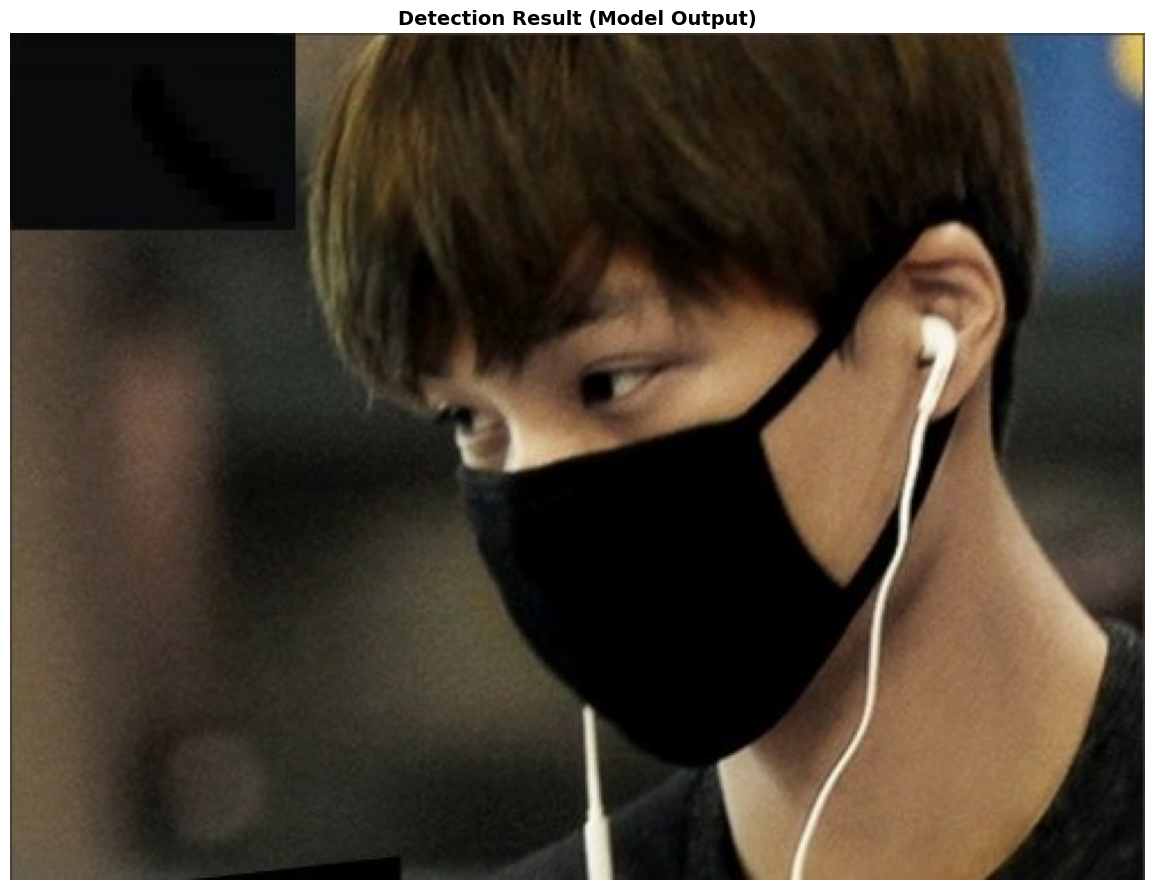

✅ Detection evaluation complete!


In [8]:
# ===== DISPLAY RESULT =====
from PIL import Image
import matplotlib.pyplot as plt

# Display saved detection result
fig, ax = plt.subplots(figsize=(12, 9))

# Load and display
result_img = Image.open(out_path)
ax.imshow(result_img)
ax.set_title("Detection Result (Model Output)", fontsize=14, fontweight='bold')
ax.axis("off")

plt.tight_layout()
plt.show()

print("✅ Detection evaluation complete!")
